In [1]:
import pretty_midi
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import sys
import os
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

print("Python version:")
print(torch.__version__)

# Use CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Python version:
2.5.1


# Exploratory Data Analysis & Data Preprocessing

In [2]:
# parse music folder to identify .mid files under each composer
dir_name = 'music'

artist_list = []
file_list = {}

directory_path = Path('music')
for file_path in directory_path.iterdir():
    if file_path.is_file():
        print(file_path)
    else:
        artist_list.append(file_path.name)

print(artist_list)

for artist_name in artist_list:
    file_list[artist_name] = []
    directory_path = Path(os.path.join('music', artist_name))
    for file_path in directory_path.iterdir():
        if file_path.is_file():
            if '.mid' in str(file_path):
                file_list[artist_name].append(str(file_path))
        else:
            directory_path_sub = Path(os.path.join('music', artist_name, file_path.name))
            for file_path2 in directory_path_sub.iterdir():
                if file_path2.is_file():
                    if '.mid' in str(file_path2):
                        file_list[artist_name].append(str(file_path2))
                else:
                    directory_path_sub_sub = Path(os.path.join('music', artist_name, file_path.name, file_path2.name))
                    for file_path3 in directory_path_sub_sub.iterdir():
                        if file_path3.is_file():
                            if '.mid' in str(file_path3):
                                file_list[artist_name].append(str(file_path3))
                        else:
                            print(file_path3)

for artist_name in artist_list:
    print(f"{artist_name} number of midi files={len(file_list[artist_name])}")

['Bach', 'Beethoven', 'Chopin', 'Mozart']
Bach number of midi files=925
Beethoven number of midi files=212
Chopin number of midi files=136
Mozart number of midi files=257


Note we have more midi files for Bach compared to other composers. We have the lowest number of midi files for Chopin. This may need to insufficient data for training our model which may result in decreased accuracy for predicting Chopin.

We decided to plot the piano roll for a random MIDI file from each composer to see what they look like.

Plotting: Bach → music\Bach\Bwv001- 400 Chorales\024505b_.mid


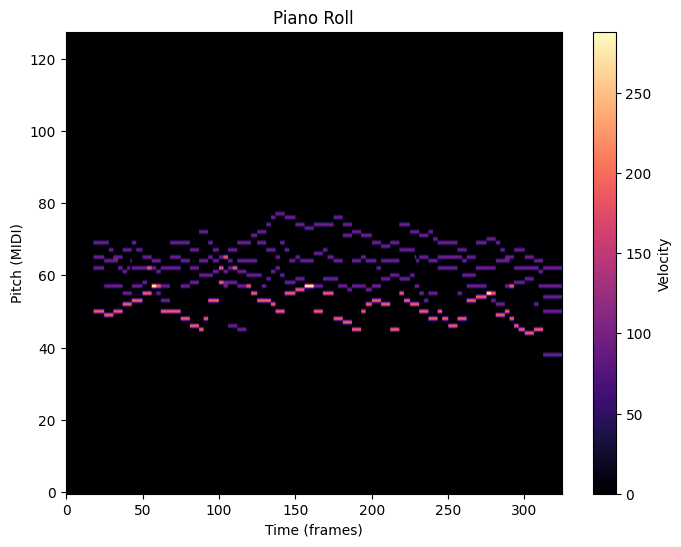

Plotting: Beethoven → music\Beethoven\Sketch for Piano Allegretto.mid


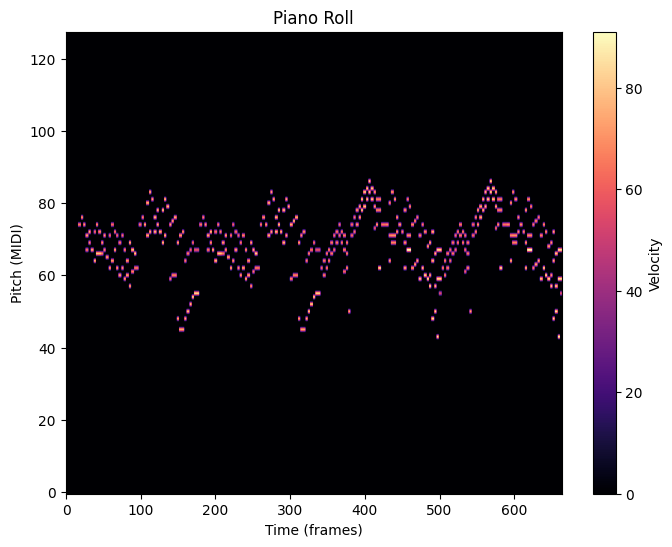

Plotting: Chopin → music\Chopin\Revolutionary.mid


c:\Users\mikes\.conda\envs\py312_pyt\Lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


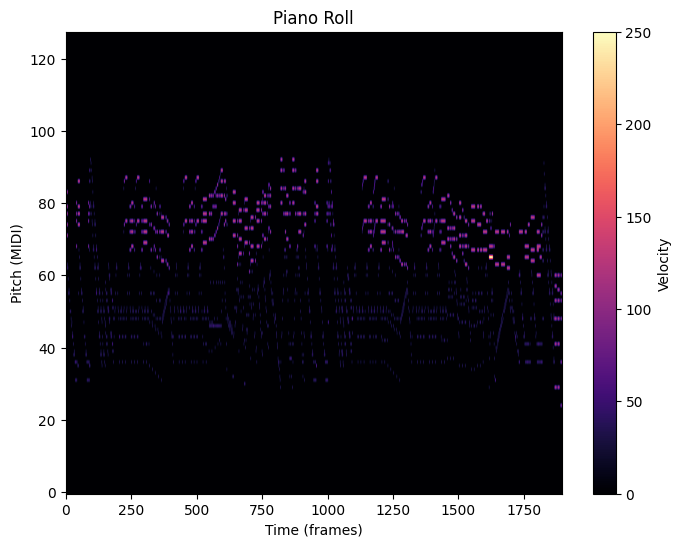

Plotting: Mozart → music\Mozart\Symphonies\Symphony n31 K297 2mov ''Paris''.mid


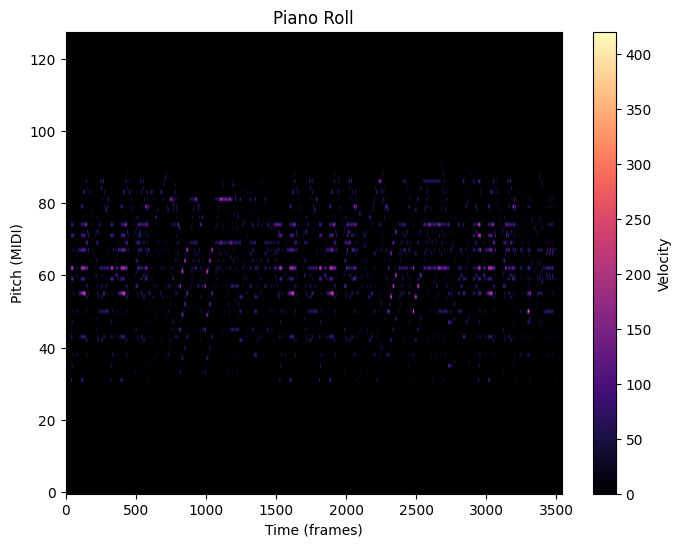

In [4]:
# visualize piano roll
def plot_piano_roll(midi_file, fs=10):
    pm = pretty_midi.PrettyMIDI(midi_file)
    roll = pm.get_piano_roll(fs=fs)
    plt.figure(figsize=(8, 6))
    plt.imshow(roll, aspect='auto', origin='lower', cmap='magma')
    plt.xlabel('Time (frames)')
    plt.ylabel('Pitch (MIDI)')
    plt.title('Piano Roll')
    plt.colorbar(label='Velocity')
    plt.show()

# plot piano roll for each composer
for composer, files in file_list.items():
    midi_path = random.choice(files)
    print(f"Plotting: {composer} → {midi_path}")
    plot_piano_roll(midi_path, fs=10)

# Feature Engineering

We initially started with just the piano roll and saw average model performance. Adding pitch class histogram, note density, and pitch transposition augmentation helped the model learned more robust features and generalize better.

In [5]:
# convert .mid file to numerical matrix (piano roll)
def midi_to_piano_roll(midi_file_path, fs=100, min_pitch=0, max_pitch=127):

    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    except Exception as e:
        print(f"Error loading MIDI file {midi_file_path}: {e}")
        return None

    # Get piano roll for all instruments
    piano_roll = midi_data.get_piano_roll(fs=fs)

    # Crop to desired pitch range
    piano_roll = piano_roll[min_pitch:max_pitch+1, :]

    pitch_range = float(max_pitch - min_pitch)

    # Normalize velocity 
    piano_roll = piano_roll / pitch_range

    return piano_roll

In [6]:
def extract_additional_features(sequence):
    # 1. Pitch class histogram, he modulo operator % 12 maps MIDI notes to their respective pitch classes (0-11).
    pitch_classes = np.arange(sequence.shape[1]) % 12
    histogram = np.zeros(12)
    # Iterate through each of the 12 pitch classes.
    for i in range(12):
        # For each pitch class sum the activity (note on/velocity)
        #  of all notes that belong to that pitch class across all time steps
        histogram[i] = sequence[:, pitch_classes == i].sum()
    
    # Normalize the histogram by the total activity in the sequence
    histogram /= (sequence.sum() + 1e-5) 

    # 2. Note density, average number of notes playing simultaneously
    note_density = np.mean(sequence.sum(axis=1)) 

    return np.concatenate([histogram, [note_density]])  

Some of the code used within 'prepare_data_for_lstm' was created with the help of Gemini Flash 2.5

In [7]:
# transform raw .mid files to sequences
# adding transposition augmentation
def prepare_data_for_lstm(sequence_length, fs=100, min_pitch=21, max_pitch=108,overlap=0, transpose_range=(-2, 2)): 
    all_sequences = []
    all_labels = []
    label_map = {}

    n_pitches = max_pitch - min_pitch + 1

    # start label ID at zero
    current_label = 0

    for artist_name in artist_list:
        print(f"Starting {artist_name} with {len(file_list[artist_name])} midi files")
        midi_files = file_list[artist_name]
        label_map[current_label] = artist_name
        
        for midi_file in midi_files:
                # Convert MIDI file into piano roll representation with shape pitches, time steps at a frequency of fs
                piano_roll = midi_to_piano_roll(str(midi_file), fs=fs, min_pitch=min_pitch, max_pitch=max_pitch)

                # Skip invalid files
                if piano_roll is None:
                    continue

                # Transpose piano_roll to (time_steps, pitches) for LSTM
                piano_roll = piano_roll.T

                # Segment the piano roll into sequences
                num_time_steps = piano_roll.shape[0]
                step_size = sequence_length - overlap
                
                # Create a sliding window to extract sequences
                for i in range(0, num_time_steps - sequence_length + 1, step_size):
                    original_seq = piano_roll[i:i + sequence_length, :]
                    # Create multiple training examples from a single sequence
                    for shift in range(transpose_range[0], transpose_range[1] + 1):
                        if shift == 0:
                            # First sequence is original sequence
                            transposed_seq = original_seq
                        else:
                            # Shift the sequence
                            transposed_seq = np.roll(original_seq, shift, axis=1)

                            # Shifting with np.roll can cause wrapping around, zero out if that occurs
                            if shift > 0:
                                transposed_seq[:, :shift] = 0
                            else:
                                transposed_seq[:, shift:] = 0

                        # Get additional features (Pitch class histogram and note density)
                        features = extract_additional_features(transposed_seq)
                        # Repeat the feature vector for each time step to allow concatenation
                        features = np.repeat(features[np.newaxis, :], sequence_length, axis=0)
                        # Combine the piano roll with the additional features
                        combined_input = np.concatenate([transposed_seq, features], axis=1)
                        
                        all_sequences.append(combined_input)
                        all_labels.append(current_label)

        if not all_sequences:
            print("No sequences processed. Check your MIDI file paths and parameters.")
            return None, None
        # Increment label Id
        current_label += 1

    X = np.array(all_sequences)
    y = np.array(all_labels)

    print(f"\nTotal sequences: {X.shape[0]}")
    print(f"Input shape (X): {X.shape} (samples, sequence_length, pitches)")
    print(f"Output shape (y): {y.shape} (samples, num_classes)")

    return X, y, label_map

In [8]:
# --- Configuration ---
SEQUENCE_LENGTH = 600 # Number of time steps in each input sequence, length in seconds is SEQUENCE_LENGTH / FS
FS = 20 # temporal resolution, increasing fs captures finer rhythmic differences
MIN_PITCH = 21 # A0, lowest note on a piano
MAX_PITCH = 108 # C8 highest note on a piano
OVERLAP = 0 # Overlap between sequences to capture more context, set to zero to prevent data snooping

# --- 1. Prepare Data ---
print("Preparing data...")
X, y, label_map = prepare_data_for_lstm(sequence_length=SEQUENCE_LENGTH, fs=FS, min_pitch=MIN_PITCH, max_pitch=MAX_PITCH, overlap=OVERLAP)

Preparing data...
Starting Bach with 925 midi files
Starting Beethoven with 212 midi files
Error loading MIDI file music\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Starting Chopin with 136 midi files
Starting Mozart with 257 midi files
Error loading MIDI file music\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2

Total sequences: 58545
Input shape (X): (58545, 600, 101) (samples, sequence_length, pitches)
Output shape (y): (58545,) (samples, num_classes)


In [9]:
# ouput label mapping for visibility
print("\nLabel to Composer Mapping:")
for label, composer in label_map.items():
    print(f"  Label {label}: {composer}")


Label to Composer Mapping:
  Label 0: Bach
  Label 1: Beethoven
  Label 2: Chopin
  Label 3: Mozart


# Model Building

### CNN-LSTM Model

For the CNN-LSTM model, we introduced 1D convolution layer to learn temporal patterns. We used the ReLU activation function after convolution. For the LSTM portion, the LSTM input size is the number of convolution output channels. The LSTM layer captures long-range dependences in the sequence. 

In [10]:
# CNN-LSTM hyrbid model
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, conv_out_channels, kernel_size,
                 lstm_hidden_size, lstm_num_layers, output_size,
                 dropout_prob=0.5, bidirectional=True):
        super(CNNLSTMClassifier, self).__init__()

        self.conv1d = nn.Conv1d(in_channels=input_size, 
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

        lstm_input_size = conv_out_channels
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            batch_first=True,
                            dropout=dropout_prob if lstm_num_layers > 1 else 0,
                            bidirectional=bidirectional)
        
        fc_input_size = lstm_hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_input_size, output_size)

    def forward(self, x):
        # CNN Part
        x = x.permute(0, 2, 1) 
        x = self.conv1d(x)
        x = self.relu(x)
        # The first dropout call has been removed.
        x = x.permute(0, 2, 1) 

        # LSTM Part
        # The LSTM layer handles hidden state initialization automatically.
        out, _ = self.lstm(x)

        # Classifier Part
        # Select the output of the last time step and apply dropout.
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        
        return out

### LSTM Model

In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional # Store bidirectional flag

        # LSTM layer with bidirectional option and dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,
                            dropout=dropout_prob if num_layers > 1 else 0,
                            bidirectional=bidirectional)

        # Dropout layer after the last LSTM output
        self.dropout = nn.Dropout(dropout_prob)

        # The input to the final FC layer doubles if bidirectional is True
        # because the outputs from the forward and backward directions are concatenated.
        fc_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(fc_input_size, output_size) 

    def forward(self, x):
        # Initialize hidden and cell states
        # For bidirectional LSTM, h0 and c0 size will be (num_layers * num_directions, batch_size, hidden_size)
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # 'out' will have shape (batch_size, sequence_length, hidden_size * num_directions)
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step.
        # For bidirectional, the last output 'out[:, -1, :]' already contains the concatenated
        # last hidden states from both forward and backward directions.
        out = self.dropout(out[:, -1, :])

        # Pass through the final fully connected layer
        out = self.fc(out)
        return out

In [12]:
# create custom dataset
class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [13]:
# Hyperparameters
num_layers = 3
hidden_size = 64
dropout = 0.2
input_size = X.shape[2]
output_size = len(artist_list)

#split sequences into train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Dataset sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# Convert to tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)

X_val = torch.from_numpy(X_val).float().to(device)
y_val = torch.from_numpy(y_val).long().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

# Create DataLoaders
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset sizes: Train=40981, Val=8782, Test=8782


### Model Training

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader):
    print(model)
    # hyperparameters
    num_epochs = 100
    train_loss_history = []
    val_loss_history = []
    min_delta = 0
    patience = 5
    best_val_loss = float('inf')

    print("\n--- Training Model ---")
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() 
        running_loss = 0.0
        for batch_sequences, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_sequences.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)

        # --- Validation Phase ---
        model.eval() 
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad(): 
            for val_sequences, val_labels in val_loader:
                val_outputs = model(val_sequences)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_sequences.size(0)

                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
            f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        
        # --- Early Stopping Check ---
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.')
                early_stop = True
                break

    if early_stop:
        # Load the best model state if early stopping occurred
        model.load_state_dict(torch.load('best_model.pth'))
        print("Loaded best model state from 'best_model.pth'")

    return model, train_loss_history, val_loss_history

In [15]:
def plot_training(train_loss_history, val_loss_history):
    # plot training loss and validation loss to visualize optimal epochs for training
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Train Loss', marker='o')
    plt.plot(val_loss_history, label='Validation Loss', marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Model Evaluation

In [16]:
def eval_model(model, criterion, test_loader):
    # run model against test holdout data
    print("\n--- Evaluating Model on Test Set ---")
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for test_sequences, test_labels in test_loader:
            test_outputs = model(test_sequences)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item() * test_sequences.size(0)

            _, predicted = torch.max(test_outputs.data, 1)
            total_test += test_labels.size(0)
            correct_test += (predicted == test_labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    test_loss = test_running_loss / total_test

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')

        # output classification report on model evaluation
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[label_map[i] for i in sorted(label_map)]))

    # output confusion matrix on model evaluation
    cm = confusion_matrix(all_labels, all_preds)
    class_names = [label_map[i] for i in sorted(label_map)]

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=plt.gca())
    plt.title("Confusion Matrix - Composer Classification")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # output model evaluation on test data by composer
    print("\n--- Evaluating Model on Test Set (Per Composer) ---")
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0

    all_preds = []
    all_labels = []

    # Initialize per-class counters
    num_classes = len(label_map)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for test_sequences, test_labels in test_loader:
            test_outputs = model(test_sequences)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item() * test_sequences.size(0)

            _, predicted = torch.max(test_outputs.data, 1)

            total_test += test_labels.size(0)
            correct_test += (predicted == test_labels).sum().item()

            # Store for confusion matrix/classification report
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

            # Update per-class accuracy counts
            for i in range(len(test_labels)):
                label = test_labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if pred == label:
                    class_correct[label] += 1

    # Overall metrics
    test_accuracy = 100 * correct_test / total_test
    test_loss = test_running_loss / total_test
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # Per-class (composer) accuracy
    print("\nPer-Composer Accuracy:")
    for i in range(num_classes):
        composer = label_map[i]
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"  {composer:15}  Accuracy: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")
        else:
            print(f"  {composer:15}  No test samples.")    

### Running LSTM Model

LSTMClassifier(
  (lstm): LSTM(101, 64, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

--- Training Model ---
Epoch 1/100, Train Loss: 1.1849, Val Loss: 1.1099, Val Acc: 50.71%
Epoch 2/100, Train Loss: 1.0461, Val Loss: 0.9457, Val Acc: 60.05%
Epoch 3/100, Train Loss: 1.0387, Val Loss: 1.0155, Val Acc: 56.78%
Epoch 4/100, Train Loss: 0.9054, Val Loss: 0.8726, Val Acc: 62.02%
Epoch 5/100, Train Loss: 0.8100, Val Loss: 0.7337, Val Acc: 70.36%
Epoch 6/100, Train Loss: 0.7323, Val Loss: 0.6878, Val Acc: 71.45%
Epoch 7/100, Train Loss: 0.6896, Val Loss: 0.6891, Val Acc: 72.31%
Epoch 8/100, Train Loss: 0.6349, Val Loss: 0.6138, Val Acc: 75.39%
Epoch 9/100, Train Loss: 0.5931, Val Loss: 0.5633, Val Acc: 77.94%
Epoch 10/100, Train Loss: 0.5573, Val Loss: 0.5492, Val Acc: 78.50%
Epoch 11/100, Train Loss: 0.5093, Val Loss: 0.5227, Val Acc: 80.00%
Epoch 12/100, Train Loss: 0.

C:\Users\mikes\AppData\Local\Temp\ipykernel_30112\372063714.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


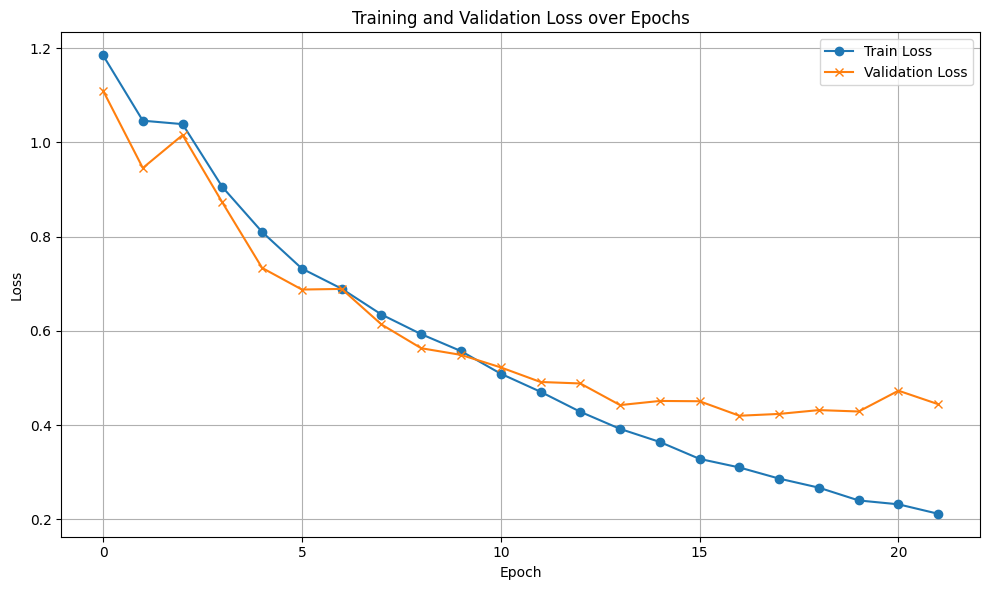


--- Evaluating Model on Test Set ---
Test Loss: 0.4458
Test Accuracy: 84.07%

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.94      0.93      3144
   Beethoven       0.80      0.78      0.79      2479
      Chopin       0.85      0.73      0.78       702
      Mozart       0.78      0.81      0.79      2457

    accuracy                           0.84      8782
   macro avg       0.84      0.81      0.82      8782
weighted avg       0.84      0.84      0.84      8782



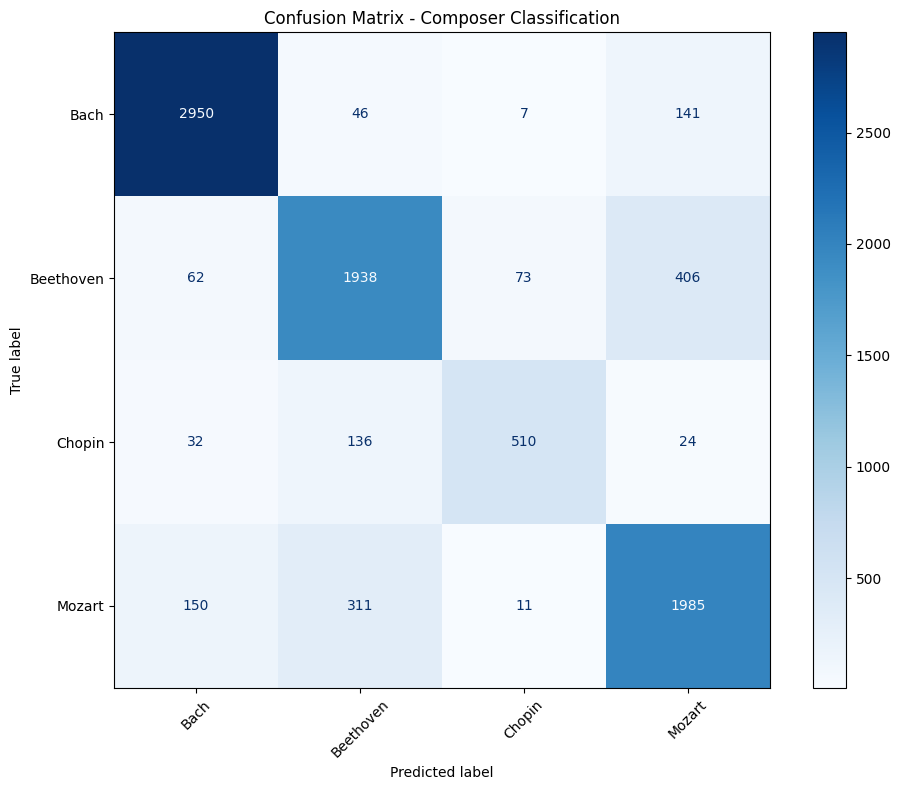


--- Evaluating Model on Test Set (Per Composer) ---
Test Loss: 0.4458
Test Accuracy: 84.07%

Per-Composer Accuracy:
  Bach             Accuracy: 93.83% (2950/3144)
  Beethoven        Accuracy: 78.18% (1938/2479)
  Chopin           Accuracy: 72.65% (510/702)
  Mozart           Accuracy: 80.79% (1985/2457)


In [17]:
# Model, Loss, Optimizer
model = LSTMClassifier(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers,
    output_size=output_size, 
    dropout_prob=dropout, 
    bidirectional=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, train_loss_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, val_loader)
plot_training(train_loss_history, val_loss_history)
eval_model(model, criterion, test_loader)



### Running CNN-LSTM Model

CNNLSTMClassifier(
  (conv1d): Conv1d(101, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(64, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

--- Training Model ---
Epoch 1/100, Train Loss: 1.1718, Val Loss: 1.0322, Val Acc: 56.82%
Epoch 2/100, Train Loss: 1.1047, Val Loss: 1.0193, Val Acc: 56.34%
Epoch 3/100, Train Loss: 1.1378, Val Loss: 1.0543, Val Acc: 56.14%
Epoch 4/100, Train Loss: 0.9869, Val Loss: 0.9302, Val Acc: 62.56%
Epoch 5/100, Train Loss: 0.9091, Val Loss: 0.8487, Val Acc: 66.10%
Epoch 6/100, Train Loss: 0.8525, Val Loss: 0.7946, Val Acc: 69.30%
Epoch 7/100, Train Loss: 0.8134, Val Loss: 0.7846, Val Acc: 68.87%
Epoch 8/100, Train Loss: 0.7576, Val Loss: 0.7228, Val Acc: 71.82%
Epoch 9/100, Train Loss: 0.7162, Val Loss: 0.6853, Val Acc: 72.75%
Epoch 10/100, Train Loss: 0.6656, Val Loss: 0.6281, Val Acc: 75.77%
Epoch 11/100, Train Loss:

C:\Users\mikes\AppData\Local\Temp\ipykernel_30112\372063714.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


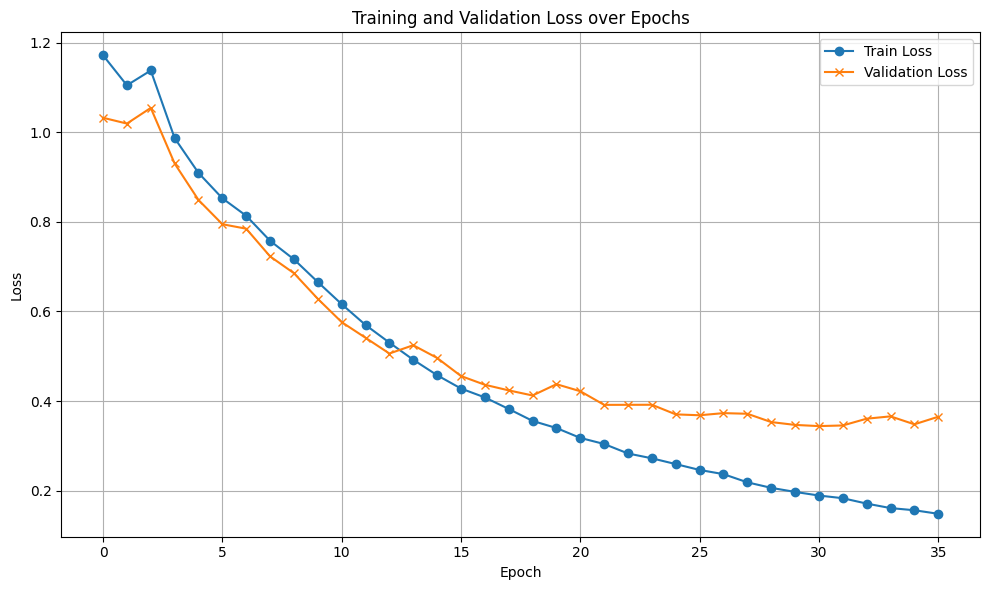


--- Evaluating Model on Test Set ---
Test Loss: 0.3351
Test Accuracy: 88.26%

Classification Report:
              precision    recall  f1-score   support

        Bach       0.94      0.96      0.95      3144
   Beethoven       0.85      0.82      0.84      2479
      Chopin       0.90      0.82      0.85       702
      Mozart       0.83      0.86      0.85      2457

    accuracy                           0.88      8782
   macro avg       0.88      0.87      0.87      8782
weighted avg       0.88      0.88      0.88      8782



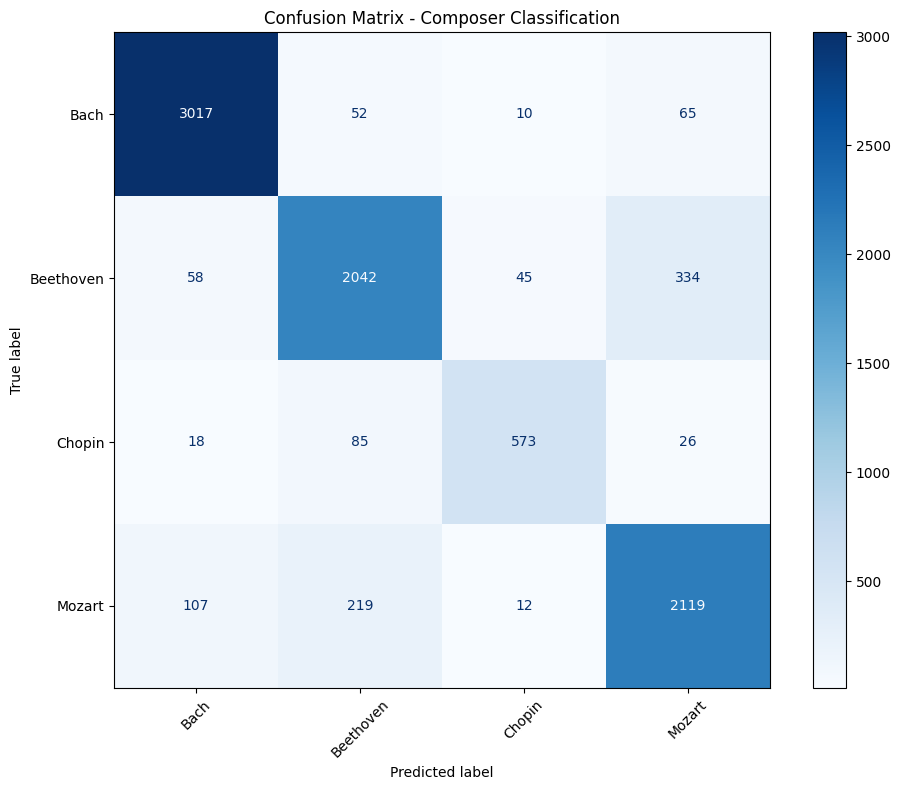


--- Evaluating Model on Test Set (Per Composer) ---
Test Loss: 0.3351
Test Accuracy: 88.26%

Per-Composer Accuracy:
  Bach             Accuracy: 95.96% (3017/3144)
  Beethoven        Accuracy: 82.37% (2042/2479)
  Chopin           Accuracy: 81.62% (573/702)
  Mozart           Accuracy: 86.24% (2119/2457)


In [21]:
# initialize CNN-LSTM Model
model = CNNLSTMClassifier(
    input_size=input_size,     
    conv_out_channels=64,
    kernel_size=3,
    lstm_hidden_size=hidden_size,
    lstm_num_layers=num_layers,
    output_size=len(artist_list),
    dropout_prob=dropout,
    bidirectional=False
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_loss_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, val_loader)
plot_training(train_loss_history, val_loss_history)
eval_model(model, criterion, test_loader)